# Add AR6 sea level proj to interpolated MLLW (along CA coast) 
 - a proxy for inundation

In [1]:
from dataclasses import dataclass
import xarray as xr
import rioxarray as xrr
from rioxarray.merge import merge_arrays
import geopandas as gpd
import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
from make_beaches import *

%matplotlib inline
%pdb off

print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())

Automatic pdb calling has been turned OFF
(SL)  2024-05-15 17:32:38.194490


In [10]:
# set these 
path_wd = '/scratch/tws_grace/data/Sea_Level/SFEI'
SLR_col = 'rsl2050'

### Setup Data

In [3]:
@dataclass
class CARIData():
    wd : str | Path = Path(os.getenv('dataroot')) / 'Sea_Level' / 'SFEI'
    
    def __post_init__(self):
        self.wd = Path(self.wd)
        self.gdf_slp = self.get_scenarios()
        self.da_mllw = self.get_mllw() # surface of the water at MLLW in NAVD88

        
    def get_scenarios(self):
        sd =  self.wd.parent / 'Projections' / 'Sea_Level_Rise_Datasets_2022'
        src = sd / 'SLR_TF_BB.GeoJSON'
        if src.exists():
            gdf = gpd.read_file(src)
            return gdf
        
        src0 = sd / 'SLR_TF U.S. Sea Level Projections.csv'
        assert src0.exists(), 'Download the SLR projections from NOAA technical report.'\

        # intersects US coastline = 1 for yes
        # RSL due to VLM (vlm): (trend: cm/year)
        # rsl values and offests are in cm
        # Scenario: For each of the 5 GMSL scenarios
        # (identified by the rise amounts in meters by 2100--0.3 m ,
        # 0.5 m. 1.0 m, 1.5 m and 2.0 m), there is a low, medium (med) and
        # high value, corresponding to the 17th, 50th, and 83rd percentiles'
        # grids are at 1º

        # use the rsl_gridnum to groupby a single pixel (15 scenarios)
        cols = 'psmsl_site psmsl_id noaa_id noaa_name rsl_gridnum lat lon '\
          'region us_coastline_intersect scenario vlm '\
          'offset_1992-2000 offset_2000-2005 rsl2005 rsl2020 rsl2030 '\
          'rsl2040 rsl2050 rsl2060 rsl2070 rsl2080 rsl2090 rsl2100 rsl2110 rsl2120 rsl2130 rsl2140 rsl2150'

        cols = cols.split() 
        df = pd.read_csv(src0, skiprows=2583, header=None)
        # get rid of extra columns at end
        df = df.iloc[:, :len(cols)]
        df.columns = cols
        df.drop(columns='psmsl_site psmsl_id noaa_id noaa_name '\
                       'us_coastline_intersect'.split(), inplace=True)

        df['gmsl'] = df['scenario'].apply(lambda x: float(x.split('-')[0]))
        df['percentile'] = df['scenario'].apply(lambda x: x.split('-')[1].lower().strip())
        df.drop(columns='scenario', inplace=True)
        gdf = bbGIS.df2gdf(df, 'all')
        gdf.to_file(src)
        ## convert the dataframe to geodataframe with all columns
        return gdf
    

    def get_mllw(self):
        path_mllw = self.wd / 'JPL_Share' / 'MLLW_NAVD88m_IDW.tif'
        ds = xrr.open_rasterio(path_mllw)
        da = ds.sel(band=1)
        da = da.where(da < 1e20, np.nan)
        da.rio.write_nodata(da.rio.nodata, encoded=True, inplace=True)

        return da

    # not actually used 
    def get_polys(self):
        paths    = (self.wd / 'CARI_polygons').glob('*.GeoJSON')
        lst_gdfs = []
        for path in paths:
            try:
                gdf = gpd.read_file(path)
            except:
                print (f'Could not open {path}')
                continue
            gdf.attrs['path'] = path
            lst_gdfs.append(gdf)

        # lst_gdfs = [gpd.read_file(path) for path in paths]
        # gdf = gpd.read_file(next(paths))
        return lst_gdfs
        
DO = CARIData(path_wd)
path_dems = DO.wd / 'dems' 

# Add Sea Level to MLLW

In [2]:
def subset_slp(gdf, percentile='med', gmsl=1, years=[2050, 2100]):
    """ Subset SLP by amount of *gmsl* in *years* for the *percentile* risk """
    gdf = gdf[gdf['percentile'] == percentile]
    gdf = gdf[gdf['gmsl'] == gmsl]
    rsl_yrs = [f'rsl{year}' for year in years]
    regions = 'southwest northwest'.split()
    gdf['region'] = gdf['region'].str.lower()
    if isinstance(regions, list):
        gdf = gdf[gdf.region.isin(regions)]
    else:
        gdf = gdf[gdf.regions == regions]
    gdf = gdf.rename(columns={'geometry':'lalo'})[rsl_yrs + ['lalo']].set_geometry('lalo')
    gdf['lat'] = gdf.lalo.y
    gdf['lon'] = gdf.lalo.x

    gdf.attrs['percentile'] = percentile
    return gdf

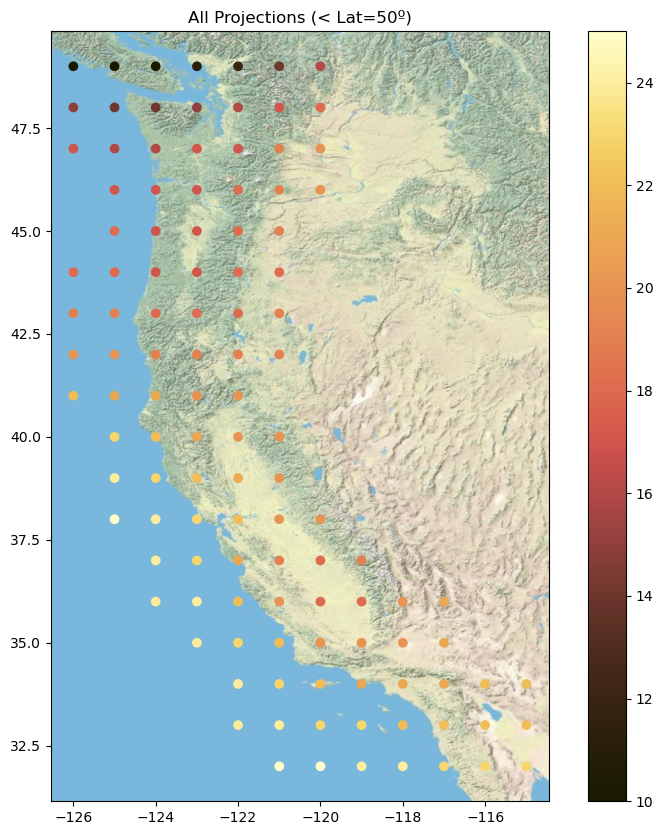

In [4]:
gdf_slp_ca = subset_slp(DO.gdf_slp)
gdf_slp_ca = gdf_slp_ca[gdf_slp_ca.lat < 50] # drop top row in Canada and on land
fig, axes = plt.subplots(figsize=(10, 10))
gdf_slp_ca.plot(column='rsl2050', cmap='cmc.lajolla', legend=True, ax=axes)
cx.add_basemap(ax=axes, crs=gdf_slp_ca.crs, source=cx.providers.Esri.WorldPhysical, attribution=False)
axes.set_title('All Projections (< Lat=50º)');

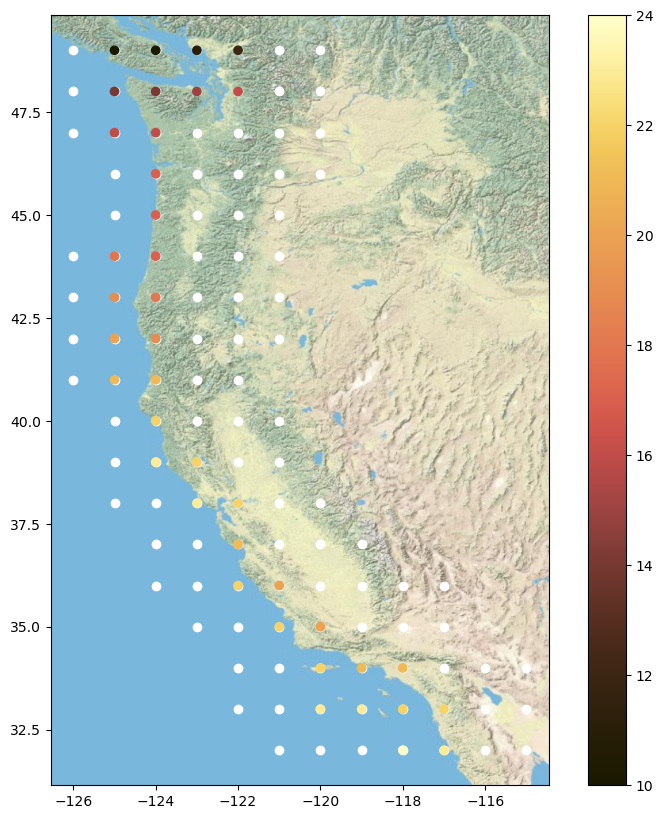

In [5]:
## subset manually from top N(0) to S(-1) 
lst_ix = (
[1, 2, 3, 4], 
[1, 2, 3, 4], 
[1, 2], 
[1],
[1],
[1,2],
[1,2],
[1,2],
[1,2],
[1],
[1, 2],
[2,3],
[2],
[2, 3],
[2, 3],
[2, 3, 4],
[2, 3, 4, 5],
[3, 4],
)

lst_gdfs = []
for i, (lat, gdf_lat) in enumerate(gdf_slp_ca.groupby("lat", sort=False)):
    if i == len(lst_ix): 
        break
    lst_gdfs.append(gdf_lat.iloc[lst_ix[i]])

df_slp_coast = pd.concat(lst_gdfs)
gdf_slp_coast = gpd.GeoDataFrame(df_slp_coast, geometry='lalo', crs=4326)

fig, axes = plt.subplots(figsize=(10, 10))
gdf_slp_ca.plot(color='white', ax=axes) # for orig points
gdf_slp_coast.plot(column='rsl2050', cmap='cmc.lajolla', legend=True, ax=axes)
cx.add_basemap(ax=axes, crs=gdf_slp_ca.crs, source=cx.providers.Esri.WorldPhysical, attribution=False)

/tmp/ipykernel_2262760/2953709129.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_slp_polys['lalo'] = gdf_slp_coast.buffer(0.5, cap_style='square')


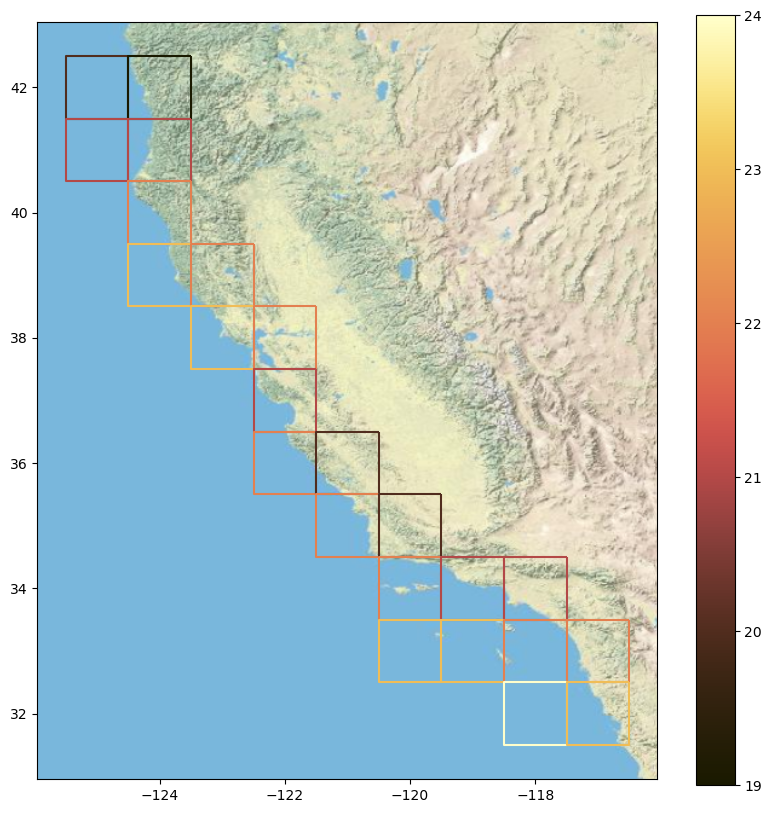

In [6]:
# make the points into regular 1º grid cells along the CA coast only
gdf_slp_polys = gdf_slp_coast[gdf_slp_coast.lat<=42.0].copy()

gdf_slp_polys['lalo'] = gdf_slp_coast.buffer(0.5, cap_style='square')
gdf_slp_polys = gpd.GeoDataFrame(gdf_slp_polys, geometry='lalo')

fig, axes = plt.subplots(figsize=(10, 10))
gdf_slp_polys.plot(column='rsl2050', cmap='cmc.lajolla', legend=True, ax=axes, facecolor='none', linewidth=1.5)
cx.add_basemap(ax=axes, crs=gdf_slp_polys.crs, source=cx.providers.Esri.WorldPhysical, attribution=False)

gdf_slp_polys0 = gdf_slp_polys.copy() # debugging

fig.set_label(f'CA_mllw_overview')
# bbPlot.savefigs(DO.wd, True, True)

### Link MLLW with Projections

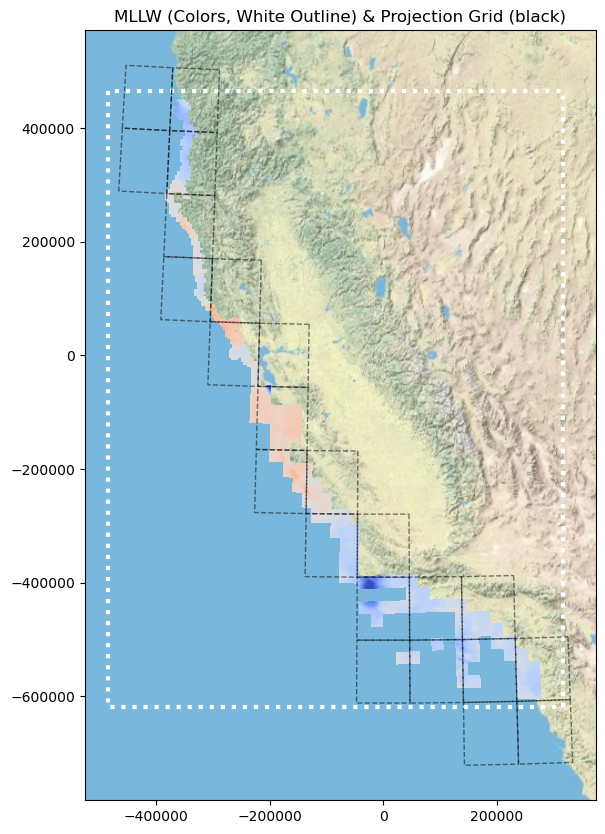

In [7]:
# show the MLLW raster on top
crs_mllw = DO.da_mllw.rio.crs
# debugging / for rerunning
try: 
    gdf_slp_polys = gdf_slp_polys.set_crs(4326).to_crs(crs_mllw)
except:
    pass
w, s, e, n = DO.da_mllw.rio.bounds()
buff = 1e3
ser_mllw_bounds = gpd.GeoSeries(box(w-buff, s-buff, e+buff, n+buff), crs=3310) # to show entire plot
                                
fig, axes = plt.subplots(figsize=(10, 10))
sty  = dict(zorder=50, alpha=0.5, facecolor='none', edgecolor='black', linestyle='--', linewidth=1)
gdf_slp_polys.plot(ax=axes, **sty)
im = axes.pcolormesh(DO.da_mllw.x, DO.da_mllw.y, DO.da_mllw, cmap='coolwarm', shading='nearest', 
            norm=mpl.colors.TwoSlopeNorm(0, -0.3, 0.3), zorder=10)
ser_mllw_bounds.plot(ax=axes, facecolor='none', edgecolor='white', linewidth=3, linestyle=':')
# bbPlot.imshow_cbar(im, 'MLLW (m)');
cx.add_basemap(ax=axes, crs=ser_mllw_bounds.crs, source=cx.providers.Esri.WorldPhysical, attribution=False)

axes.set_title('MLLW (Colors, White Outline) & Projection Grid (black)');

### Run Processing

In [8]:
# for each coastal grid cell, get the MLLW raster values and add the projection to it
# SLR_col = '0'
lst_das = []
for ix, row in gdf_slp_polys.iterrows():
    if SLR_col == '0':
        slr = 0
    else:
        slr = row[SLR_col] / 100 # cm to meters
    da_mllw_crop = DO.da_mllw.rio.clip([row['lalo']], crs_mllw, drop=False)
    # drop polygons (projections) in PNW and Mexico
    if da_mllw_crop.isnull().all():
        continue
    lst_das.append(da_mllw_crop+slr)

lbl = f'{gdf_slp_ca.attrs["percentile"]}_{SLR_col}' if not SLR_col == '0' else SLR_col
da_mllw_slr = xr.concat(lst_das, dim='tmp').mean('tmp').assign_attrs(label=lbl)

dst = DO.wd / f'MLLW_SLR_{lbl}.tif'
da_mllw_slr.rio.to_raster(dst)
print (f'Wrote: {dst}')

Wrote: /scratch/tws_grace/data/Sea_Level/SFEI/MLLW_SLR_med_rsl2050.tif


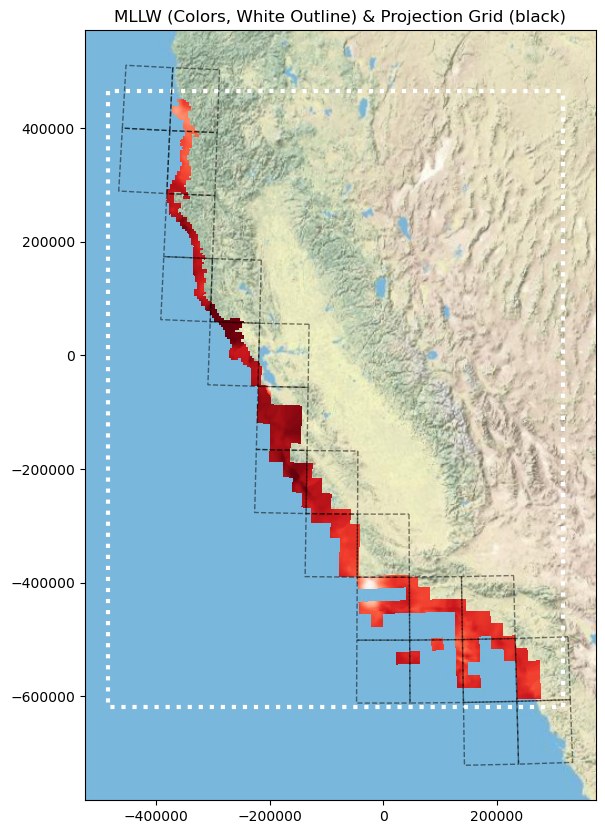

In [9]:
# show the MLLW raster on top
crs_mllw = DO.da_mllw.rio.crs
# debugging
try:
    gdf_slp_polys = gdf_slp_polys.set_crs(4326).to_crs(crs_mllw)
except:
    pass
w, s, e, n = da_mllw_slr.rio.bounds()
buff = 1e3
ser_mllw_bounds = gpd.GeoSeries(box(w-buff, s-buff, e+buff, n+buff), crs=3310) # to show entire plot
                                
fig, axes = plt.subplots(figsize=(10, 10))
sty  = dict(zorder=50, alpha=0.5, facecolor='none', edgecolor='black', linestyle='--', linewidth=1)
gdf_slp_polys.plot(ax=axes, **sty)

cmap, norm = ('coolwarm', mpl.colors.TwoSlopeNorm(0)) if slr == 0 else ('Reds', mpl.colors.Normalize(-0.1, 0.3))
im = axes.pcolormesh(da_mllw_slr.x, da_mllw_slr.y, da_mllw_slr, shading='nearest',zorder=10,cmap=cmap, norm=norm)

ser_mllw_bounds.plot(ax=axes, facecolor='none', edgecolor='white', linewidth=3, linestyle=':')
# bbPlot.imshow_cbar(im, 'm', ylabel=f'MLLW {lbl}')
cx.add_basemap(ax=axes, crs=ser_mllw_bounds.crs, source=cx.providers.Esri.WorldPhysical, attribution=False)

axes.set_title('MLLW (Colors, White Outline) & Projection Grid (black)')

fig.set_label(f'CA_mllw_{SLR_col}')
# bbPlot.savefigs(DO.wd, True, True)

In [ ]:
## project the MLLW to the El Nino CCRS and get bounds

# for plotting
da_mllw_slr_wgs = da_mllw_slr.rio.reproject(4326)
da_mllw_slr_wgs = da_mllw_slr_wgs.where(da_mllw_slr_wgs < 1e20, np.nan)
da_mllw_slr_wgs.rio.write_nodata(da_mllw_slr_wgs.rio.nodata, encoded=True, inplace=True);

In [ ]:
# reclassify using the DEM

# ZT -> dune toe
# MAH -> max annual height from tide gauge


# Rocky Intertidal:
# SetNull(CoNED < MLLW | (CoNED > MAH & ElNino > MAH))

# Rocky Intertidal with Beach: 
# SetNull(CoNED < MLLW | (CoNED > MHW & ElNino > MHW)

# Beach: 
# SetNull(CoNED < MLLW | (CoNED > ZT & ElNino > ZT)


### Old 
-  more automated, but lacks coverage

In [ ]:
# remove points projections on land
da_wmask = xrr.open_rasterio(DO.wd / 'OSM_wmask.tif').sel(band=1) # make with cells at bottom
# da_wmask.plot() ## might crash

ix_keep = []
for i, lalo in enumerate(gdf_slp_ca.lalo):
    x, y, = lalo.x, lalo.y
    maskv = da_wmask.sel(x=x, y=y, method='nearest').item()
    if not maskv:
        ix_keep.append(i)
gdf_slp_ca_w = gdf_slp_ca.reset_index(drop=True)
gdf_slp_ca_w = gdf_slp_ca_w[gdf_slp_ca_w.index.isin(ix_keep)]

In [ ]:
fig, axes = plt.subplots(figsize=(10, 10))
gdf_slp_ca_w.plot(column='rsl2050', cmap='cmc.lajolla', legend=True, ax=axes)
cx.add_basemap(ax=axes, crs=gdf_slp_ca_w.crs, source=cx.providers.Esri.WorldPhysical, attribution=False)

In [ ]:
# get the points in the actual coastal ocean
sers_coast = []
for lat, dfi in gdf_slp_ca_w.groupby('lat'):

    if lat in [47, 49]: # some weird land points
        loc = -2
    
    elif lat == 34: # get the catalina island points too
        loc = [-3, -2, -1] 
    else:  # grab the eastern most non-masked point
        loc = -1

    loc = dfi.sort_values('lon').iloc[loc]
    # make consistent since series/dfs
    if isinstance(loc, pd.Series):
        sers_coast.append(loc.to_frame().T)
    else:
        sers_coast.append(pd.DataFrame(loc))

df_slp_coast = pd.concat(sers_coast)
gdf_slp_coast = gpd.GeoDataFrame(df_slp_coast, geometry='lalo', crs=4326)

fig, axes = plt.subplots(figsize=(10, 10))
gdf_slp_ca_w.plot(color='white', ax=axes) # for orig points
gdf_slp_coast.plot(column='rsl2050', cmap='cmc.lajolla', legend=True, ax=axes)
cx.add_basemap(ax=axes, crs=gdf_slp_ca_w.crs, source=cx.providers.Esri.WorldPhysical, attribution=False)

In [ ]:
# make the points into regular 1º grid cells 
gdf_slp_polys = df_slp_coast.copy()

gdf_slp_polys['lalo'] = gdf_slp_coast.buffer(0.5, cap_style='square')
gdf_slp_polys = gpd.GeoDataFrame(gdf_slp_polys, geometry='lalo')

fig, axes = plt.subplots(figsize=(10, 10))
gdf_slp_polys.plot(column='rsl2050', cmap='cmc.lajolla', legend=True, ax=axes)
cx.add_basemap(ax=axes, crs=gdf_slp_polys.crs, source=cx.providers.Esri.WorldPhysical, attribution=False)

gdf_slp_polys0 = gdf_slp_polys.copy() # debugging

In [ ]:
# buffer them east so that overlap with land where the MLLW dataset is
from shapely.geometry import Polygon
ebuff = 0.7
ebuff_bounds = gdf_slp_polys['lalo'].apply(lambda geom: Polygon(list(geom.exterior.coords) + 
                                        [(coord[0] + ebuff, coord[1]) for coord in geom.exterior.coords])).bounds

polys = [Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)]) for minx, miny, maxx, maxy in 
         zip(ebuff_bounds['minx'], ebuff_bounds['miny'], ebuff_bounds['maxx'], ebuff_bounds['maxy'])]

gdf_slp_polys['lalo'] = polys

fig, axes = plt.subplots(figsize=(10, 10))
gdf_slp_polys.plot(column='rsl2050', cmap='cmc.lajolla', legend=True, ax=axes)
cx.add_basemap(ax=axes, crs=gdf_slp_polys.crs, source=cx.providers.Esri.WorldPhysical, attribution=False)

In [ ]:
# to view in QGIS
cols_cvt = gdf_slp_polys.filter(like='rsl').columns
gdf_slp_polys[cols_cvt] = gdf_slp_polys[cols_cvt].astype(float)
gdf_slp_polys.to_file(DO.wd / 'projection_polys.GeoJSON')

In [ ]:
# to view in QGIS
cols_cvt = gdf_slp_polys.filter(like='rsl').columns
gdf_slp_polys[cols_cvt] = gdf_slp_polys[cols_cvt].astype(float)
dst = DO.wd / 'projection_polys.GeoJSON'
gdf_slp_polys.to_file(dst)
print ('Wrote projection grids to:', dst)

#### Download Water Mask

Just for finding the projection points at the coast

In [ ]:
SNWE = gdf_slp_ca.lat.min(), gdf_slp_ca.lat.max(), gdf_slp_ca.lon.min(), gdf_slp_ca.lon.max()
S0 = 5 * int(np.floor(SNWE[0]/5))
W0 = np.abs(5 * int(np.floor(SNWE[2]/5)))

sn = 'n' if S0 > 0 else 's'
ew = 'e' if SNWE[2] > 0 else 'w'

tiles = [f'{sn}{S0:02}{ew}{W0:03}.tif']
for y in range(30, 55, 5):
    for x in range(115, 135, 5):
        tiles.append(f'n{y}w{x}.tif')

In [ ]:
path_cropdir = Path(os.getenv('dataroot')) /  'OSM_WaterLayer_tif'

# after downloading and extracting identify the tile(s)
src = [str(path_cropdir/tile) for tile in tiles]
dst = DO.wd / 'OSM_wmask.tif'
os.remove(dst) if op.exists(dst) else ''

cmd = f'gdal_merge.py -o {dst} {" ".join(src)} -of "GTiff" -a_nodata 2'
print (cmd)
!{cmd}

mask_file = gdal.Open(str(dst), gdal.GA_Update)
arr       = mask_file.ReadAsArray()

# 0 is land in dst; convert that its own land value
arr       = np.where(arr==0, 6, arr) 
# convert all water classes except small tributaries & canals to 0
arr       = np.where(arr<4, 0, 1) 
# plt.imshow(arr, cmap='binary_r'); plt.colorbar()


err_code   = mask_file.GetRasterBand(1).WriteArray(arr)
if err_code == 0:
    print (f'Wrote: {dst}')
else:
    print ('Error writing array')
del mask_file

In [ ]:
# check coverage
da_wmask = xrr.open_rasterio(DO.wd / 'OSM_wmask.tif').sel(band=1)
S, N, W, E = SNWE

print ('S extent is okay?', da_wmask.y.min().item() < S)
print ('N extent is okay?', da_wmask.y.max().item() > N)

print ('W extent is okay?', da_wmask.x.min().item() < W)
print ('E extent is okay?', da_wmask.x.max().item() > E)